In [123]:
import sys
import os
from typing import Optional
from tqdm import tqdm
sys.path.append(os.path.abspath('../'))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
import seaborn as sns
import os
from IPython.display import display, HTML
import torch
from scipy.stats import bootstrap
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score

from utils.plot_utils import *
from utils.utils import *

pd.set_option('display.max_rows', 500)

In [139]:
count_inf = -10
experiment_dir = "/n/holylabs/LABS/sitanc_lab/Users/mfli/critical-windows-lm/results/JailbreakLikelihoodRatio/JailbreakLikelihoodRatio_aligned_model=meta-llama-Llama-3.1-8B-Instruct_dataset=sevdeawesome-jailbreak_success_num_samples=1000/"

logprob_cols = sum([[f"{prefix}_logprobs_sum",f"{prefix}_logprobs_inf",f"{prefix}_logprobs_len"] for prefix in ["user","asst","gen"]], [])

In [125]:
aligned_jailbreak_graded = torch.load(f"{experiment_dir}/aligned_jailbreak_graded.pt")
aligned_jailbreak_logprobs = torch.load(f"{experiment_dir}/aligned_jailbreak_logprobs.pt")
aligned_benign_logprobs = torch.load(f"{experiment_dir}/aligned_benign_logprobs.pt")

unaligned_jailbreak_graded = torch.load(f"{experiment_dir}/unaligned_jailbreak_graded.pt")
unaligned_jailbreak_logprobs = torch.load(f"{experiment_dir}/unaligned_jailbreak_logprobs.pt")
unaligned_benign_logprobs = torch.load(f"{experiment_dir}/unaligned_benign_logprobs.pt")

/tmp/ipykernel_1939548/3154204259.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  aligned_jailbreak_graded = torch.load(f"{experiment_dir}/aligned_jailbreak_graded.pt")


In [126]:
def pt_to_df(jailbreak_graded=None, jailbreak_logprobs=None, count_inf=None):
    if jailbreak_graded:
        jailbreak_graded_df = []
        for row in tqdm(jailbreak_graded):
            copy_row = row.copy()
            del copy_row["input_tokens"], copy_row["response_tokens"]
            jailbreak_graded_df.append(copy_row)
        jailbreak_graded_df    = pd.DataFrame(jailbreak_graded_df)
    if jailbreak_logprobs:
        jailbreak_logprobs_df = []
        for row in jailbreak_logprobs:
            copy_row = row.copy()
            del copy_row["input_tokens"], copy_row["response_tokens"]
            for prefix in ["user","asst","gen"]:
                arr = np.array(row[f"{prefix}_logprobs"])
                copy_row[f"{prefix}_logprobs_sum"] = np.sum(arr[np.isfinite(arr)])
                copy_row[f"{prefix}_logprobs_inf"] = len(arr[~np.isfinite(arr)])
                copy_row[f"{prefix}_logprobs_len"] = len(arr)
                if count_inf:
                    copy_row[f"{prefix}_logprobs_inf_sum"] = count_inf * copy_row[f"{prefix}_logprobs_inf"] + copy_row[f"{prefix}_logprobs_sum"]
                del copy_row[f"{prefix}_logprobs"]
            jailbreak_logprobs_df.append(copy_row)
        jailbreak_logprobs_df  = pd.DataFrame(jailbreak_logprobs_df)
    
    if jailbreak_graded and jailbreak_logprobs:
        print(jailbreak_graded_df.columns)
        print(jailbreak_graded_df.shape)
        print(jailbreak_graded_df.drop_duplicates().shape)
        print(len(jailbreak_graded_df.jailbreak_prompt_text.unique()))
        print(len(jailbreak_logprobs_df.jailbreak_prompt_text.unique()))
        jailbreak_df_gpby = jailbreak_graded_df.groupby(["jailbreak_prompt_text"])["grader_answer"].mean().reset_index()
        print(jailbreak_df_gpby.shape)
        jailbreak_text_logprobs = jailbreak_df_gpby.merge(jailbreak_logprobs_df[["jailbreak_prompt_text"]+logprob_cols],on=["jailbreak_prompt_text"],how="inner")
        print(jailbreak_text_logprobs.shape)
        return jailbreak_text_logprobs
    elif jailbreak_graded:
        return jailbreak_graded_df
    elif jailbreak_logprobs:
        return jailbreak_logprobs_df

## ROC curves between benign and jailbreaks

In [132]:
def plot_ROC(train_statistics, val_statistics, plot_title, keep_first=None, ci=True, num_bootstraps=1000, fprs=None, log_scale=False, show_plot=True, save_name=None, lims=None, color='darkorange'):
    '''
    Plots ROC curve with train and validation test statistics. Also saves TPRs at FPRs.
    
    **Note that we assume train statistic < test statistic. Negate before using if otherwise.**

    Args:
        train_statistics (list[float]): list of train statistics
        val_statistics (list[float]): list of val statistics
        plot_title (str): title of the plot
        ci (bool): compute confidence intervals. Default: True
        num_bootstraps (int): number of bootstraps for confidence interval
        keep_first (int): compute only for the first keep_first number of samples
        show_plot (bool): whether to show the plot
        save_name (str): save path for plot and scores (without extension); does not save unless save_name is specified
        log_scale (bool): whether to plot on log-log scale
        lims (list): argument to xlim and ylim
        fprs (list[float]): return TPRs at given FPRs. If unspecified, calculates at every 0.1 increment
        color (str): color
    
    Returns:
        auc (float): the ROC-AUC score
        tpr_at_fprs (list[float]): the tprs at the given fprs
    '''
    # Preprocess
    train_statistics = torch.as_tensor(train_statistics).flatten()[:keep_first]
    train_statistics = train_statistics[~train_statistics.isnan()]
    val_statistics = torch.as_tensor(val_statistics).flatten()[:keep_first]
    val_statistics = val_statistics[~val_statistics.isnan()]

    ground_truth = torch.cat((torch.ones_like(train_statistics),torch.zeros_like(val_statistics))).flatten()
    predictions = torch.cat((-train_statistics,-val_statistics)).flatten()
    n_points = len(ground_truth)

    fpr, tpr, thresholds = roc_curve(ground_truth,predictions)
    roc_auc = auc(fpr, tpr)

    # Process FPRs
    if fprs is None:
        fprs = [0.01,0.05,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
    tpr_at_fprs = [tpr[np.max(np.argwhere(fpr<=fpr_val))] for fpr_val in fprs]
    
    # Compute CI
    if ci:
        fpr_range = np.linspace(0, 1, n_points)
        def auc_statistic(data,axis):
            ground_truth = data[0,0,:].T
            predictions = data[1,0,:].T
            fpr, tpr, thresholds = roc_curve(ground_truth, predictions)
            roc_auc = auc(fpr, tpr)
            tpr_range = np.interp(fpr_range,fpr,tpr)
            return np.array([[roc_auc]+tpr_range.tolist()]).T
        
        data = torch.cat((ground_truth[:,None],predictions[:,None]),dim=1)
        bootstrap_result = bootstrap((data,), auc_statistic, confidence_level=0.95, n_resamples=num_bootstraps, batch=1, method='percentile',axis=0)
        auc_se = bootstrap_result.standard_error[0]
        tpr_se = [bootstrap_result.standard_error[np.max(np.argwhere(fpr_range<=fpr_val))] for fpr_val in fprs]

    # Plot
    plt.figure(figsize=(7,7),dpi=300)
    plt.plot([0, 1], [0, 1], linestyle="--", c="k")
    if not log_scale:
        plt.plot(fpr, tpr, label=f'AUC = {roc_auc:0.4f}',c=color)
        plt.xlim([0,1] if lims is None else lims)
        plt.ylim([0,1] if lims is None else lims)
    else:
        plt.loglog(fpr, tpr, label=f'AUC = {roc_auc:0.4f}',c=color)
        plt.xlim([10**(-int(np.log10(n_points))),1] if lims is None else lims)
        plt.ylim([10**(-int(np.log10(n_points))),1] if lims is None else lims)
    if ci:
        plt.fill_between(fpr_range,bootstrap_result.confidence_interval.low[1:],bootstrap_result.confidence_interval.high[1:],alpha=0.1,color=color)
    plt.title(plot_title)
    plt.legend(loc="lower right")
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.gca().set_aspect('equal', adjustable='box')
    plt.minorticks_on()
    plt.grid(which="major",alpha=0.2)
    plt.grid(which="minor",alpha=0.1)

In [140]:
aligned_jb_logprobs_df = pt_to_df(None, aligned_jailbreak_logprobs, count_inf)
unaligned_jb_logprobs_df = pt_to_df(None, unaligned_jailbreak_logprobs, count_inf) 

aligned_benign_logprobs_df = pt_to_df(None, aligned_benign_logprobs, count_inf)
unaligned_benign_logprobs_df = pt_to_df(None, unaligned_benign_logprobs, count_inf) 

In [143]:
jailbreak_diff = (unaligned_jb_logprobs_df["asst_logprobs_inf_sum"]-aligned_jb_logprobs_df["asst_logprobs_inf_sum"])/unaligned_jb_logprobs_df["asst_logprobs_len"]
benign_diff = (unaligned_benign_logprobs_df["asst_logprobs_inf_sum"]-aligned_benign_logprobs_df["asst_logprobs_inf_sum"])/unaligned_benign_logprobs_df["asst_logprobs_len"]

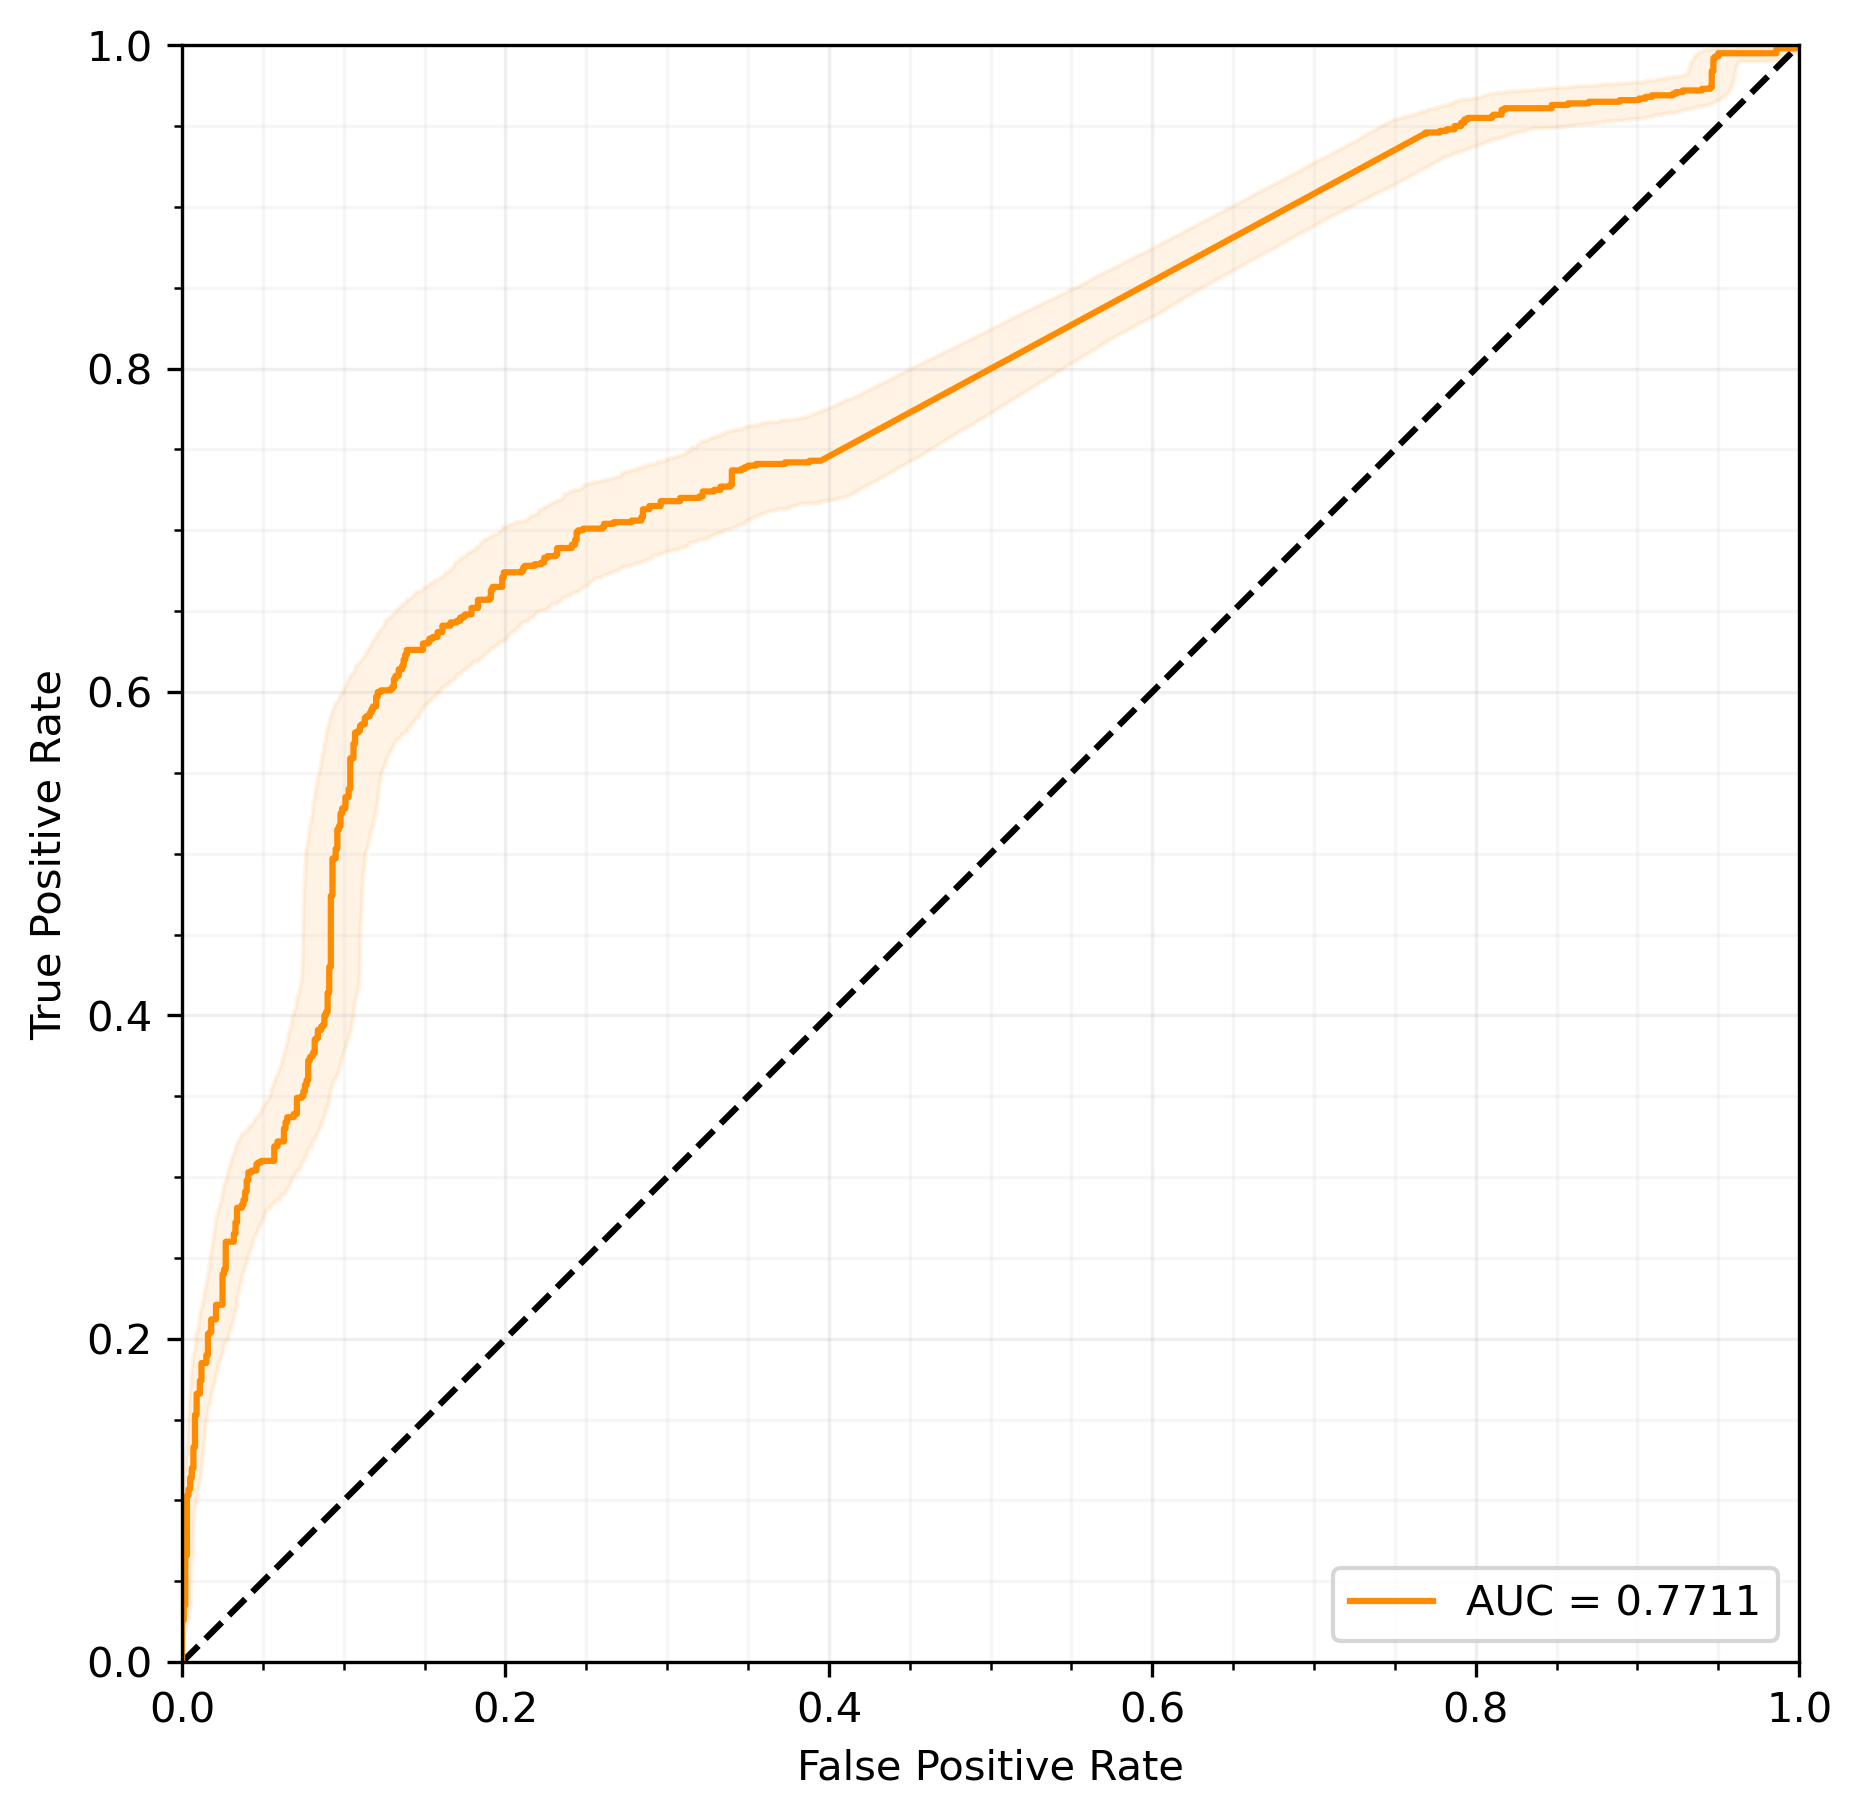

In [144]:
plot_ROC(-jailbreak_diff, -benign_diff,plot_title="")

In [149]:
aligned_txt_logprobs = pt_to_df(aligned_jailbreak_graded, aligned_jailbreak_logprobs)
unaligned_txt_logprobs = pt_to_df(unaligned_jailbreak_graded, unaligned_jailbreak_logprobs)

100%|█████████████████████████████████████████████████████████████████████████████████████████████| 25000/25000 [00:00<00:00, 718453.71it/s]


Index(['prompt_name', 'jailbreak_prompt_name', 'jailbreak_prompt_text',
       'original_prompt_text', 'toxic_type', 'context', 'length',
       'response_string', 'no', 'grader_answer'],
      dtype='object')
(25000, 10)
(24755, 10)
896
896
(896, 2)
(1000, 11)


100%|████████████████████████████████████████████████████████████████████████████████████████████| 25000/25000 [00:00<00:00, 1065658.51it/s]


Index(['prompt_name', 'jailbreak_prompt_name', 'jailbreak_prompt_text',
       'original_prompt_text', 'toxic_type', 'context', 'length',
       'response_string', 'no', 'grader_answer'],
      dtype='object')
(25000, 10)
(24967, 10)
896
896
(896, 2)
(1000, 11)


In [7]:
for prefix in ["user","asst","gen"]:
    unaligned_txt_logprobs[f"{prefix}_logprobs_inf_sum"] = count_inf * unaligned_txt_logprobs[f"{prefix}_logprobs_inf"] + unaligned_txt_logprobs[f"{prefix}_logprobs_sum"]
    aligned_txt_logprobs[f"{prefix}_logprobs_inf_sum"] = count_inf * aligned_txt_logprobs[f"{prefix}_logprobs_inf"] + aligned_txt_logprobs[f"{prefix}_logprobs_sum"]
    aligned_txt_logprobs[f"{prefix}_logprobs_diff"] = (unaligned_txt_logprobs[f"{prefix}_logprobs_inf_sum"]-aligned_txt_logprobs[f"{prefix}_logprobs_inf_sum"])/aligned_txt_logprobs[f"{prefix}_logprobs_len"]

In [20]:
aligned_txt_logprobs["user_logprobs_diff_bin"] = pd.qcut(aligned_txt_logprobs["user_logprobs_diff"],6,precision=2)
aligned_txt_logprobs["user_logprobs_diff_bin"]

0       (-0.7, -0.5]
1       (-0.5, -0.3]
2       (-0.7, -0.5]
3       (-0.7, -0.5]
4       (-0.7, -0.5]
           ...      
995    (-2.59, -0.7]
996    (-2.59, -0.7]
997    (-2.59, -0.7]
998     (-0.7, -0.5]
999     (-0.7, -0.5]
Name: user_logprobs_diff_bin, Length: 1000, dtype: category
Categories (6, interval[float64, right]): [(-2.59, -0.7] < (-0.7, -0.5] < (-0.5, -0.3] < (-0.3, -0.16] < (-0.16, 0.029] < (0.029, 0.56]]

In [21]:
aligned_txt_logprobs.groupby("user_logprobs_diff_bin")["grader_answer"].agg(["mean","sem"])

/tmp/ipykernel_1759450/1484735564.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  aligned_txt_logprobs.groupby("user_logprobs_diff_bin")["grader_answer"].agg(["mean","sem"])


,mean,sem
user_logprobs_diff_bin,,
"(-2.59, -0.7]",0.040479,0.012550
"(-0.7, -0.5]",0.067229,0.018003
"(-0.5, -0.3]",0.019415,0.008662
"(-0.3, -0.16]",0.166871,0.024027
"(-0.16, 0.029]",0.196867,0.025121
"(0.029, 0.56]",0.467066,0.033971


/tmp/ipykernel_1759450/1781614410.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  data=aligned_txt_logprobs.groupby("user_logprobs_diff_bin")["grader_answer"].agg(["mean","sem"]).reset_index(),
/tmp/ipykernel_1759450/1781614410.py:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(
/tmp/ipykernel_1759450/1781614410.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


ConversionError: Failed to convert value(s) to axis units: 'sem'

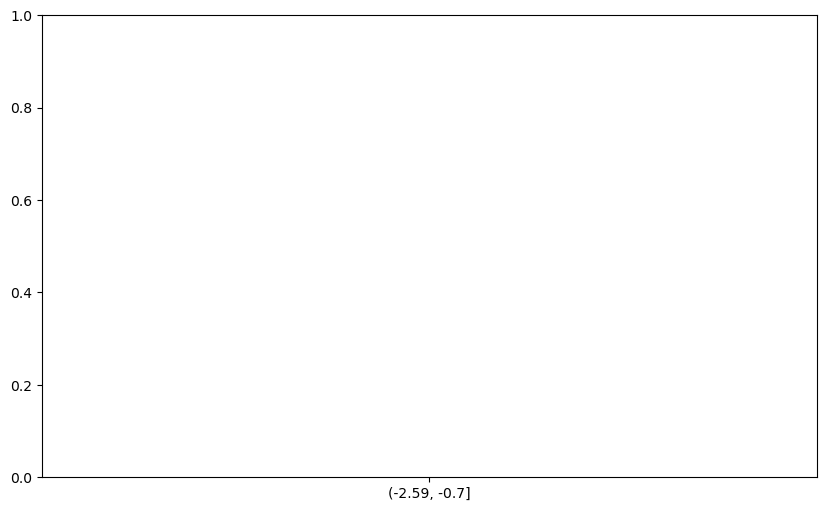

In [27]:


# Plotting the data
plt.figure(figsize=(10, 6))
sns.barplot(
    x="user_logprobs_diff_bin",
    y="mean",
    yerr="sem",
    data=aligned_txt_logprobs.groupby("user_logprobs_diff_bin")["grader_answer"].agg(["mean","sem"]).reset_index(),
    palette="Blues_d",
    ci=None
)
plt.xlabel("User Logprobs Diff Bin")
plt.ylabel("Mean Grader Answer with SEM")
plt.title("Mean Grader Answer by Logprobs Diff Bin with SEM")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()